In [11]:
import pandas as pd
import numpy as np

In [12]:
import tensorflow as tf 
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

# Load in the data
cifar10 = tf.keras.datasets.cifar10
 
# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

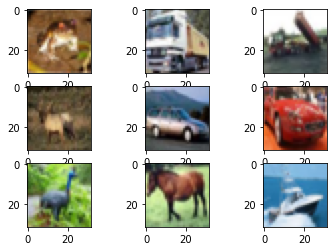

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# display a subset of images
def display_img(count, x_train):
    for i in range(count):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(x_train[i])
    # show the figure
    plt.show()

display_img(9, x_train)

In [14]:
#flatten data into vectors. Each image vector is 3,072 numbers long (32 x 32 x 3 color channels)
def img_to_vector(x):
    return np.reshape(x, (x_train.shape[0], -1))

In [15]:
#normalize data 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# calculate mean and standard deviation
x_mean = np.mean(x_train)
x_std = np.std(x_train)

#x_train = (x_train - x_mean) / x_std
#x_test = (x_test - x_mean) / x_std

#pixel values between 0 and 1
x_train  /= 255
x_test /= 255

# one-hot encode labels
#y_train = tf.one_hot(y_train, depth=len(np.unique(y_train)))
#y_test = tf.one_hot(y_test, depth=len(np.unique(y_test)))

In [16]:
x_train_flat = np.reshape(x_train, (x_train.shape[0], -1)) # [49000, 3072]
x_test_flat = np.reshape(x_test, (x_test.shape[0], -1)) # [10000, 3072]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
#y_train, y_test = y_train.flatten(), y_test.flatten()
y_train

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train_flat, y_train.ravel())
predict = model.predict(x_test_flat)
model.score(x_test_flat, y_test)

0.3398

In [18]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
    

# number of classes
K = len(np.unique(y_train))
 
# calculate total number of classes
# for output layer
print("number of classes:", K)

# input layer
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

# Hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# last hidden layer i.e.. output layer
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

# model description
model.summary()

number of classes: 10
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (No

In [19]:
# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# Fit
r = model.fit(
  x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
1563/1563 [==============================] - 112s 72ms/step - loss: 1.3282 - accuracy: 0.5433 - val_loss: 0.9433 - val_accuracy: 0.6661
Epoch 2/50
1563/1563 [==============================] - 113s 72ms/step - loss: 0.8624 - accuracy: 0.7028 - val_loss: 0.8711 - val_accuracy: 0.7085
Epoch 3/50
1563/1563 [==============================] - 112s 72ms/step - loss: 0.6946 - accuracy: 0.7618 - val_loss: 0.7132 - val_accuracy: 0.7553
Epoch 4/50
1563/1563 [==============================] - 113s 72ms/step - loss: 0.5823 - accuracy: 0.7986 - val_loss: 0.7285 - val_accuracy: 0.7582
Epoch 5/50
1563/1563 [==============================] - 112s 72ms/step - loss: 0.4865 - accuracy: 0.8340 - val_loss: 0.7221 - val_accuracy: 0.7656
Epoch 6/50
1563/1563 [==============================] - 113s 72ms/step - loss: 0.4132 - accuracy: 0.8579 - val_loss: 0.6503 - val_accuracy: 0.7905
Epoch 7/50
1563/1563 [==============================] - 112s 72ms/step - loss: 0.3500 - accuracy: 0.8793 - val_loss: 0

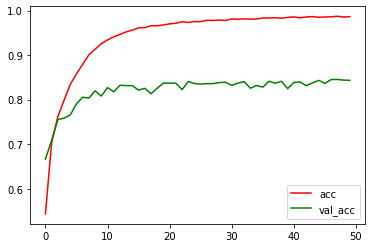

In [42]:
plt.plot(r.history['accuracy'], label='acc', color='red')
plt.plot(r.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

Original label is cat and predicted label is cat


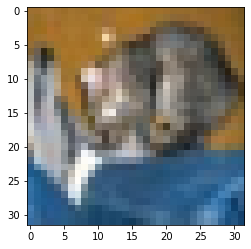

In [36]:
# select the image from our test dataset
image_number = 0
 
# display the image
plt.imshow(x_test[image_number])
 
# load the image in an array
n = np.array(x_test[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = labels[model.predict(p).argmax()]
 
# load the original label
original_label = labels[y_test.flatten()[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))

In [21]:
from art.attacks.evasion import DeepFool
from art.estimators.classification import KerasClassifier
# Create classifier wrapper
classifier = KerasClassifier(model=model)
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

# Craft adversarial samples with DeepFool
print("Create DeepFool attack")
adv_crafter = DeepFool(classifier)
print("Craft attack on training examples")
x_train_adv = adv_crafter.generate(x_train)
print("Craft attack test examples")
x_test_adv = adv_crafter.generate(x_test)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 103s 2ms/sample - loss: 1.5475 - accuracy: 0.5091
Epoch 2/10
50000/50000 [==============================] - 89s 2ms/sample - loss: 0.8899 - accuracy: 0.6870
Epoch 3/10
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.6839 - accuracy: 0.7622
Epoch 4/10
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.5648 - accuracy: 0.8019
Epoch 5/10
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.4574 - accuracy: 0.8373
Epoch 6/10
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.3841 - accuracy: 0.8650
Epoch 7/10
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.3108 - accuracy: 0.8906
Epoch 8/10
50000/50000 [==============================] - 91s 2ms/sample - loss: 0.2566 - accuracy: 0.9105
Epoch 9/10
50000/50000 [==============================] - 87s 2ms/sample - loss: 0.2181 - accuracy: 0.9238
Epoch 10/10
5

DeepFool:   0%|          | 0/50000 [00:00<?, ?it/s]

Craft attack test examples


DeepFool:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
# Evaluate the classifier on the adversarial samples
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Classifier before adversarial training")
print("Accuracy on adversarial samples: %.2f%%", (acc * 100))

Classifier before adversarial training
Accuracy on adversarial samples: %.2f%% 7.33


In [23]:
# Data augmentation: expand the training set with the adversarial samples
x_train = np.append(x_train, x_train_adv, axis=0)
y_train = np.append(y_train, y_train, axis=0)

In [24]:
# Retrain the CNN on the extended dataset
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

Train on 100000 samples
Epoch 1/10
100000/100000 [==============================] - 197s 2ms/sample - loss: 0.9311 - accuracy: 0.6753
Epoch 2/10
100000/100000 [==============================] - 199s 2ms/sample - loss: 0.5705 - accuracy: 0.8020
Epoch 3/10
100000/100000 [==============================] - 199s 2ms/sample - loss: 0.4237 - accuracy: 0.8534
Epoch 4/10
100000/100000 [==============================] - 198s 2ms/sample - loss: 0.3323 - accuracy: 0.8870
Epoch 5/10
100000/100000 [==============================] - 195s 2ms/sample - loss: 0.2780 - accuracy: 0.9045
Epoch 6/10
100000/100000 [==============================] - 195s 2ms/sample - loss: 0.2394 - accuracy: 0.9191
Epoch 7/10
100000/100000 [==============================] - 195s 2ms/sample - loss: 0.2047 - accuracy: 0.9311
Epoch 8/10
100000/100000 [==============================] - 196s 2ms/sample - loss: 0.1817 - accuracy: 0.9390
Epoch 9/10
100000/100000 [==============================] - 196s 2ms/sample - loss: 0.1628 - acc

In [25]:
# Evaluate the adversarially trained classifier on the test set
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Classifier with adversarial training")
print("Accuracy on adversarial samples: %.2f%%", (acc * 100))

Classifier with adversarial training
Accuracy on adversarial samples: %.2f%% 11.899999999999999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label is plane and predicted label is truck


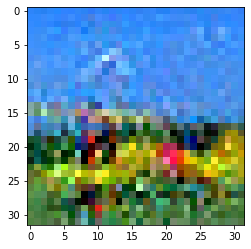

In [41]:
# label mapping
 
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 
# select the image from our test dataset
image_number = 44
 
# display the image
plt.imshow(x_test_adv[image_number])
 
# load the image in an array
n = np.array(x_test_adv[image_number])
 
# reshape it
p = n.reshape(1, 32, 32, 3)
# pass in the network for prediction and
# save the predicted label
predicted_label = labels[model.predict(p).argmax()]
 
# load the original label
original_label = labels[y_test.flatten()[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))